# Assignment – Long Short-Term Memory Neural Networks (LSTM) für Zeitreihen

Bern University of Applied Sciences – CAS AI HS 25
Dozent: Ilja Rasin  

Dieses Notebook gehört zur dritten Vorlesung (RNN).

**Ziele dieser Einheit**

- Grundidee von RNN / LSTM im Kontext von Zeitreihen verstehen  
- Eine synthetische Zeitreihe (Sinus + Rauschen) vorhersagen  
- Ein einfaches LSTM-Modell in PyTorch implementieren  
- Train/Validation/Test-Split und Fensterbildung für Time Series anwenden  
- Optional: Eigene Zeitreihe laden (z.B. S&P500 mit `yfinance`) und ausprobieren

**Hinweis für Studierende (Assignment-Charakter)**

- Lest das Notebook von oben nach unten.  
- Führt alle Zellen aus und versucht, jeden Schritt zu verstehen.  
- Die Aufgabenabschnitte (*Aufgaben*) enthalten konkrete Experimente, die ihr selbst durchführen sollt.


In [1]:
# 1. Imports und Basiskonfiguration

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Matplotlib Standard-Einstellungen (keine speziellen Farben)
plt.rcParams["figure.figsize"] = (10, 4)

# Reproduzierbarkeit: Zufalls-Saat setzen
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 2. Synthetische Zeitreihe: Sinus + Rauschen

Wir beginnen mit einer **einfachen künstlichen Zeitreihe**, an der sich das Verhalten eines RNN gut demonstrieren lässt:

$
x_t = \sin(\omega t) + \epsilon_t
$

mit etwas Rauschen ($\epsilon_t\$).

Später können wir **eigene Zeitreihen** (z.B. S&P500) an derselben Pipeline ausprobieren.


In [2]:
# 2.1 Zeitachse und Sinus-Zeitreihe erzeugen

n_points = 1000          # Anzahl der Zeitpunkte
t_max = 50               # "Zeit" (x-Achse) bis wohin wir gehen
t = np.linspace(0, t_max, n_points)

# Sauberer Sinus
signal_clean = np.sin(2 * math.pi * t / 10.0)  # Periode ~10

# Rauschen hinzufügen
noise = 0.3 * np.random.randn(n_points)
signal_noisy = signal_clean + noise

# In Torch-Tensor umwandeln
series = torch.tensor(signal_noisy, dtype=torch.float32)
series.shape


torch.Size([1000])

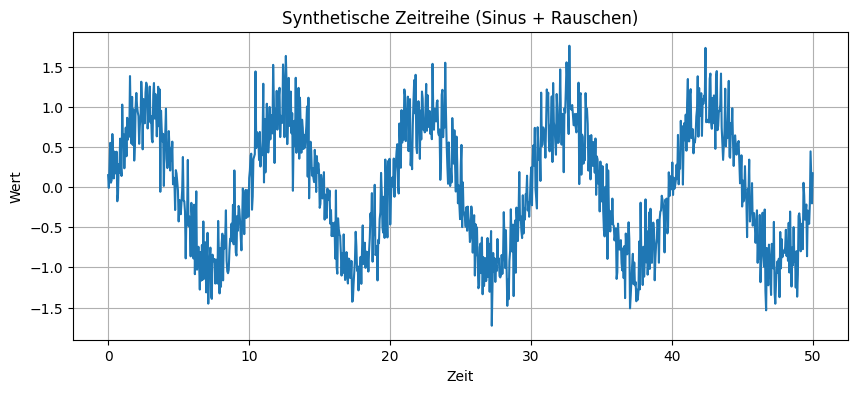

In [3]:
# 2.2 Visualisierung der Zeitreihe

plt.plot(t, series.numpy())
plt.title("Synthetische Zeitreihe (Sinus + Rauschen)")
plt.xlabel("Zeit")
plt.ylabel("Wert")
plt.grid(True)
plt.show()


## 3. Fensterbildung (Sequences) für RNN

Ein RNN erwartet **Sequenzen** als Input, z.B.:

- Eingabe:  $x\_{t-29}, ..., x\_{t}$   (Fensterlänge = 30)
- Ziel:     $x\_{t+1}$                (1-Schritt-Vorhersage)

Wir definieren eine Funktion, die aus einem 1D-Tensor (Zeitreihe)
Input-Sequenzen und Zielwerte erzeugt.

Später können wir dieselbe Funktion auch für echte Zeitreihen verwenden.


In [4]:
# 3.1 Hilfsfunktion: aus 1D-Serie Fenster (Input, Target) erzeugen

def create_sequences(series: torch.Tensor, window_size: int, horizon: int = 1):
    """
    Erzeugt Eingabe-/Ziel-Paare aus einer 1D-Zeitreihe.

    series:      1D Tensor der Länge N
    window_size: Anzahl der Vergangenheitswerte pro Input-Sequenz
    horizon:     wie viele Schritte in die Zukunft vorhergesagt werden (hier: 1)

    Rückgabe:
        X: Tensor der Form (num_samples, window_size)
        y: Tensor der Form (num_samples, horizon)
    """
    xs = []
    ys = []

    N = len(series)
    # Letzter Index, bei dem noch ein vollständiges Fenster + Horizon möglich ist
    last_idx = N - window_size - horizon + 1

    for start in range(last_idx):
        end = start + window_size
        target_start = end
        target_end = end + horizon

        x_window = series[start:end]
        y_window = series[target_start:target_end]

        xs.append(x_window)
        ys.append(y_window)

    X = torch.stack(xs)  # (num_samples, window_size)
    y = torch.stack(ys)  # (num_samples, horizon)

    return X, y


window_size = 30     # Länge des historischen Fensters
horizon = 1          # 1-Schritt-Vorhersage

X_all, y_all = create_sequences(series, window_size, horizon)
X_all.shape, y_all.shape


(torch.Size([970, 30]), torch.Size([970, 1]))

## 4. Train/Validation/Test-Split

Wir teilen die generierten Fenster in drei Teile:

- **Train**: für das Lernen der Gewichte  
- **Validation**: zur Hyperparameter-Abstimmung  
- **Test**: zur finalen Evaluation

Wir verwenden einen einfachen Split nach Zeit (kein Mischen, um Leckage zu vermeiden).


In [5]:
# 4.1 Zeitlicher Split der Sequenzen

num_samples = X_all.shape[0]

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(num_samples * train_ratio)
val_end = train_end + int(num_samples * val_ratio)

X_train = X_all[:train_end]
y_train = y_all[:train_end]

X_val = X_all[train_end:val_end]
y_val = y_all[train_end:val_end]

X_test = X_all[val_end:]
y_test = y_all[val_end:]

X_train.shape, X_val.shape, X_test.shape


(torch.Size([679, 30]), torch.Size([145, 30]), torch.Size([146, 30]))

In [6]:
# 4.2 Dataset- und DataLoader-Klassen

class TimeSeriesDataset(Dataset):
    """
    Einfache Dataset-Klasse für Zeitreihenfenster.
    """

    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        # X: (num_samples, window_size)
        # y: (num_samples, horizon)
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_seq = self.X[idx]  # (window_size,)
        y_val = self.y[idx]  # (horizon,)

        # RNN/LSTM erwartet Input der Form (batch, seq_len, input_size)
        # Hier: input_size = 1, also wir erweitern die letzte Dimension
        x_seq = x_seq.unsqueeze(-1)  # (window_size, 1)

        return x_seq, y_val


batch_size = 32

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 5. LSTM-Modell definieren

Wir verwenden ein einfaches LSTM (statt plain RNN), weil es in der Praxis
bei längeren Sequenzen stabiler ist.

**Eingabeform**:  
- Batch:   \(B\)  
- Zeit:    \(T\) (Fensterlänge)  
- Feature: \(F = 1\) (ein Skalar pro Zeitschritt)

LSTM-Ausgabe:  
- Wir nehmen den **letzten Zeitschritt** der Hidden States und leiten ihn
  über ein Fully-Connected-Layer auf die gewünschte Horizon-Dimension (hier: 1) ab.


In [7]:
# 5.1 LSTM-Modellklasse

class LSTMForecaster(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 32, num_layers: int = 1, output_size: int = 1):
        """
        Einfacher LSTM-basierter Forecaster.

        input_size:  Dimension der Eingabefeatures (hier 1)
        hidden_size: Größe des verborgenen Zustands
        num_layers:  Anzahl der LSTM-Schichten
        output_size: Anzahl der vorherzusagenden Werte (Horizon)
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # (batch, seq_len, input_size)
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: Tensor der Form (batch, seq_len, input_size)
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        # lstm_out: (batch, seq_len, hidden_size)

        # Wir nehmen den letzten Zeitschritt der Ausgabe
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Lineare Projektion auf die Zielgröße
        out = self.fc(last_output)       # (batch, output_size)
        return out


model = LSTMForecaster(input_size=1, hidden_size=32, num_layers=1, output_size=horizon).to(device)
model


LSTMForecaster(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

##5a. Verständis von LSTM

Dieses Kapitel erklärt, was ein LSTM im Vorwärtslauf zurückgibt und wie diese Werte zu interpretieren sind. Die Darstellung ist bewusst klar und didaktisch gehalten.

### 1. Was gibt ein LSTM zurück?
Verständnis der Zeile `lstm_out, (h_n, c_n) = self.lstm(x)`

**Input** $x$ für LSTM:

1. batch size = B
2. sequence length = T
3. feature size = F

$x$ hat die Form (B, T, F)

**Output**: Ein LSTM in PyTorch liefert zwei Hauptbestandteile:


1. `lstm_out` – die Hidden States für jeden Zeitschritt  
2. `(h_n, c_n)` – das finale Hidden- und Cell-State nach dem letzten Zeitschritt

Typische Zeile:

```python
lstm_out, (h_n, c_n) = self.lstm(x)
```

### 2. Bedeutung von `lstm_out`

Ein LSTM erzeugt für jeden Zeitschritt ein Hidden State.  
`lstm_out` enthält alle diese Hidden States.

Form:

```
lstm_out.shape = (Batch, Seq_Length, Hidden_Size)
```

Für Forecasting wird meist nur der letzte Zeitschritt verwendet:

```python
last_output = lstm_out[:, -1, :]
```

### 3. Bedeutung von `h_n` (Hidden State)

`h_n` ist der finale Hidden State:

```
h_n.shape = (num_layers, Batch, Hidden_Size)
```

Eigenschaften:
- Kurzzeitgedächtnis  
- Direkter Repräsentant der Sequenz  
- Wird zur Ausgabe weiterverwendet

### 4. Bedeutung von `c_n` (Cell State)

`c_n` ist der finale Zustand des Langzeitgedächtnisses.

```
c_n.shape = (num_layers, Batch, Hidden_Size)
```

Eigenschaften:
- Langzeitgedächtnis  
- Transportiert Information über längere Zeit  
- Stabilisiert das Lernen gegenüber RNN

### 5. Warum gibt es zwei Zustände?

LSTM besitzt zwei Speicher:

1. Hidden State `h_t` – kurzfristige Information  
2. Cell State `c_t` – langfristige Information

Diese Zweiteilung unterscheidet LSTM wesentlich von einfachen RNNs.

### 6. Formen der Rückgabewerte

Wenn:
- `num_layers = L`  
- `hidden_size = H`  
- Batch Size = B  

dann:

```
lstm_out: (B, T, H)
h_n:      (L, B, H)
c_n:      (L, B, H)
```

### 7. Mehrschichtiges LSTM (Stacked LSTM)

Beispiel:

```python
nn.LSTM(input_size=1, hidden_size=32, num_layers=2)
```

Dies bedeutet:
- Zwei LSTM-Schichten übereinander  
- Jede Schicht hat eigene Hidden- und Cell-States

Visualisierung:

```
Zeit t:   Layer1 -> Layer2
Zeit t+1: Layer1 -> Layer2
```

### 8. Unterschied RNN vs. LSTM

Einfaches RNN:
- Nur ein Zustand `h_t`  
- Vergisst schnell

LSTM:
- Zwei Zustände `h_t` und `c_t`  
- Kann Langzeitabhängigkeiten abbilden  
- Besser für Zeitreihen geeignet

### 9. Zusammenfassung

- `lstm_out` enthält Hidden States aller Zeitschritte  
- `h_n` ist der letzte Hidden State  
- `c_n` ist der letzte Cell State  
- LSTM hat Kurz- und Langzeitgedächtnis  
- Mehrschichtiges LSTM stapelt mehrere LSTM-Blöcke  




## 6. Training vorbereiten

- Loss-Funktion: Mean Squared Error (MSE)  
- Optimizer: Adam  
- Epochen: z.B. 30

Wir werten pro Epoche auch die Validation-Loss aus.


In [8]:
# 6.1 Loss und Optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30


In [9]:
# 6.2 Trainingsschleife

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        running_train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)            # (batch, seq_len, 1)
            y_batch = y_batch.to(device)            # (batch, horizon)

            optimizer.zero_grad()

            y_pred = model(x_batch)                 # (batch, horizon)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                running_val_loss += loss.item() * x_batch.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoche {epoch:02d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoche 01 | Train Loss: 0.5146 | Val Loss: 0.4838
Epoche 02 | Train Loss: 0.3171 | Val Loss: 0.1542
Epoche 03 | Train Loss: 0.1362 | Val Loss: 0.1187
Epoche 04 | Train Loss: 0.1204 | Val Loss: 0.0990
Epoche 05 | Train Loss: 0.1121 | Val Loss: 0.0981
Epoche 06 | Train Loss: 0.1115 | Val Loss: 0.0920
Epoche 07 | Train Loss: 0.1081 | Val Loss: 0.0901
Epoche 08 | Train Loss: 0.1071 | Val Loss: 0.0896
Epoche 09 | Train Loss: 0.1063 | Val Loss: 0.0919
Epoche 10 | Train Loss: 0.1055 | Val Loss: 0.0904
Epoche 11 | Train Loss: 0.1055 | Val Loss: 0.0931
Epoche 12 | Train Loss: 0.1040 | Val Loss: 0.0900
Epoche 13 | Train Loss: 0.1045 | Val Loss: 0.0890
Epoche 14 | Train Loss: 0.1033 | Val Loss: 0.0928
Epoche 15 | Train Loss: 0.1042 | Val Loss: 0.0924
Epoche 16 | Train Loss: 0.1034 | Val Loss: 0.0933
Epoche 17 | Train Loss: 0.1037 | Val Loss: 0.0951
Epoche 18 | Train Loss: 0.1046 | Val Loss: 0.0899
Epoche 19 | Train Loss: 0.1050 | Val Loss: 0.0884
Epoche 20 | Train Loss: 0.1036 | Val Loss: 0.0919


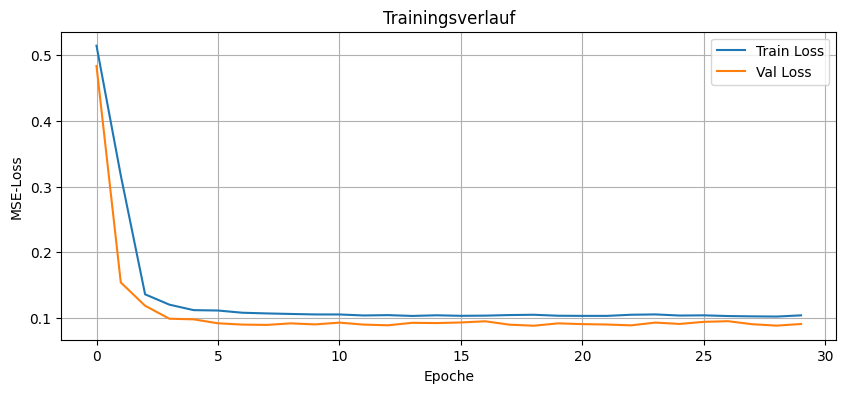

In [10]:
# 6.3 Verlauf der Trainings- und Validierungs-Fehler

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoche")
plt.ylabel("MSE-Loss")
plt.title("Trainingsverlauf")
plt.legend()
plt.grid(True)
plt.show()


## 7. Evaluation auf dem Test-Set

Wir lassen das trainierte Modell Vorhersagen auf dem Test-Set machen und
vergleichen sie mit den echten Werten der Zeitreihe.


In [11]:
# 7.1 Vorhersage-Funktion

def predict_on_loader(model, data_loader):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            preds.append(y_pred.cpu())
            targets.append(y_batch.cpu())

    preds = torch.cat(preds, dim=0)     # (num_samples, horizon)
    targets = torch.cat(targets, dim=0) # (num_samples, horizon)
    return preds, targets


y_test_pred, y_test_true = predict_on_loader(model, test_loader)
y_test_pred.shape, y_test_true.shape


(torch.Size([146, 1]), torch.Size([146, 1]))

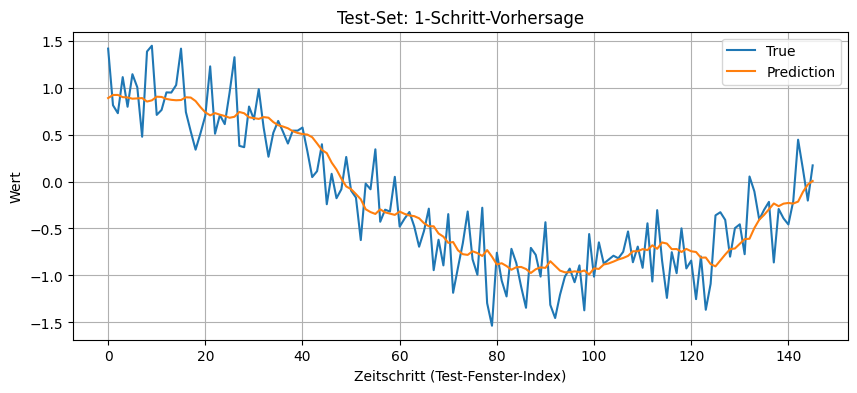

In [12]:
# 7.2 Visualisierung: Test-Vorhersagen vs. wahre Werte

# Wir nehmen hier die 1-Schritt-Vorhersage und plotten sie
pred_np = y_test_pred.squeeze(-1).numpy()
true_np = y_test_true.squeeze(-1).numpy()

plt.plot(true_np, label="True")
plt.plot(pred_np, label="Prediction")
plt.title("Test-Set: 1-Schritt-Vorhersage")
plt.xlabel("Zeitschritt (Test-Fenster-Index)")
plt.ylabel("Wert")
plt.legend()
plt.grid(True)
plt.show()


## 8. Aufgaben für Studierende

1. **Fensterlänge verändern**  
   - Ändern Sie `window_size` (z.B. 10, 50, 100).  
   - Erneut trainieren und beobachten, wie sich Training und Test-Fehler verändern.

2. **Hidden Size und Layers variieren**  
   - Probieren Sie `hidden_size = 16` und `hidden_size = 64`.  
   - Fügen Sie eine zweite LSTM-Schicht hinzu (`num_layers = 2`).  
   - Diskutieren Sie Overfitting / Underfitting anhand der Verlaufsplots.

3. **RNN statt LSTM** (optional)  
   - Ersetzen Sie `nn.LSTM` durch `nn.RNN` und passen Sie den Code an.  
   - Vergleichen Sie die Ergebnisse (Stabilität, Loss, Verlauf).

4. **Mehrschritt-Vorhersage** (optional)  
   - Setzen Sie `horizon = 5` und passen Sie Modell und Visualisierung an.  
   - Lassen Sie das Modell 5 Schritte in die Zukunft vorhersagen.

5. **Eigene Zeitreihe**  
   - Nutzen Sie den Abschnitt mit `yfinance` unten, um z.B. den S&P500 zu laden.  
   - Verwenden Sie die gleiche Fensterlogik (`create_sequences`) und dasselbe Modell.  
   - Hinweis: Finanzzeitreihen sind extrem verrauscht. Erwarten Sie keine gute Vorhersage –  
     Ziel ist das methodische Verständnis, nicht ein Trading-System.


## 9. Eigene Zeitreihe (z. B. S&P 500 mit yfinance)

In diesem Abschnitt zeigen wir, wie man eine **reale Zeitreihe** (z.B. den S&P500 Index)
herunterlädt und mit derselben RNN-Pipeline verarbeitet.

> Hinweis:  
> - Für Finanzzeitreihen ist 1-Schritt-Forecasting mit so einfachen Modellen meist **schwach**.  
> - Nehmen Sie das als experimentelles Beispiel, nicht als Investitions-Ratgeber :-)


In [13]:
# 9.1 Installation von yfinance (in Colab meist notwendig)
# In Jupyter/Colab einmal ausführen, in lokalen Umgebungen ggf. in der Shell installieren.
#!pip install yfinance

# 9.2 Daten mit yfinance laden

import yfinance as yf

# Beispiel: S&P 500 Index (^GSPC)
sp500 = yf.download("^GSPC", start="2015-01-01", end=None)

sp500.head()


/tmp/ipykernel_33534/763297122.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2015-01-01", end=None)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


In [14]:
# 9.3 Einfaches Preprocessing: wir nehmen den Close
# und normalisieren ihn grob.

close = sp500["Close"].dropna()
close_values = close.values.astype(np.float32)

# In Torch-Tensor umwandeln
sp_series = torch.tensor(close_values, dtype=torch.float32).squeeze(-1)
sp_series.shape

# Optional: Normierung (z.B. z-Score)
mean_sp = sp_series.mean()
std_sp = sp_series.std()

sp_series_norm = (sp_series - mean_sp) / std_sp
sp_series_norm.shape


torch.Size([2737])

In [15]:
# 9.4 Fenster und Split erzeugen (wie oben)

window_size_sp = 30
horizon_sp = 1

X_sp, y_sp = create_sequences(sp_series_norm, window_size_sp, horizon_sp)

### Lösung hier

In [16]:
# 9.5 Neues Modell für S&P500 trainieren

### Lösung hier
